In [1]:
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Task 1 : Visualize the images and create the atlases

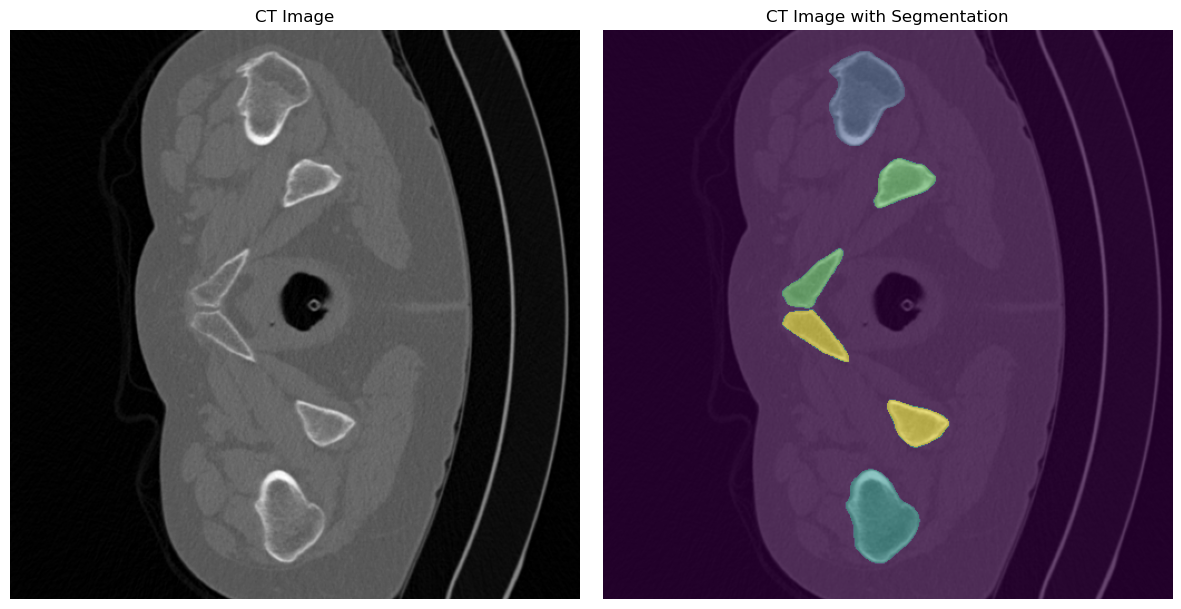

In [2]:
# Path to the NIfTI files
ct_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii" 
mask_path = r"Dataset\COMMON_images_masks\common_40_mask.nii"
# ct_image_path = r"Dataset\GROUP_images\g1_54_image.nii"

ct_image = nib.load(ct_image_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

def visualize_slice_and_mask(ct_image, mask, slice_idx):
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.imshow(mask[:, :, slice_idx], alpha=0.5)
    plt.title("CT Image with Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


slice_idx = ct_image.shape[2] // 2 -100
visualize_slice_and_mask(ct_image, mask, slice_idx)


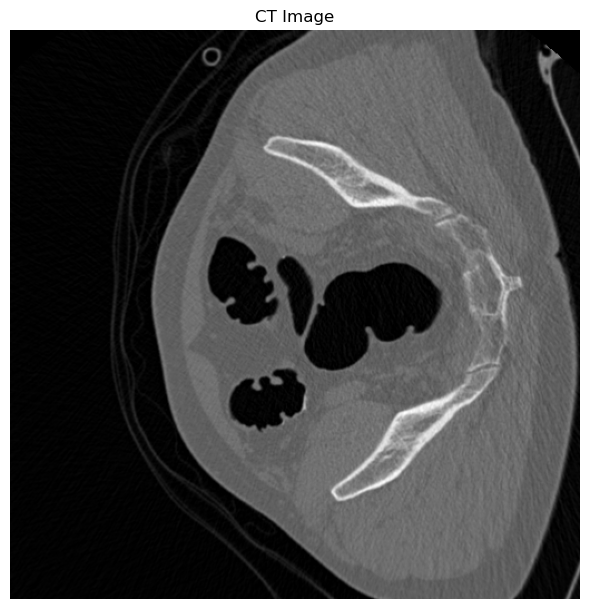

In [3]:
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

ct_image_path = r"Dataset\GROUP_images\g1_55_image.nii" 
ct_image = nib.load(ct_image_path).get_fdata()
slice_idx = ct_image.shape[2] // 2
visualize_slice(ct_image,slice_idx)

# There is two types of dataset :

* First one : COMMON => 3 patients/CT scans that are already segmented => We have to segment the left femur and hip bones

* Second one : GROUP => We can take groupe 1 files = 3 patients/CT scans : they are not segmented at all, we have to do the segmentation manually

In [5]:
import os

common_dir = r"Dataset\COMMON_images_masks" 
output_dir = r"Dataset\Output_mask"  

os.makedirs(output_dir, exist_ok=True)


LEFT_FEMUR = 2  
LEFT_HIP_BONE = 4  
RIGHT_HIP_BONE = 3

mask_files = [f for f in os.listdir(common_dir) if "_mask.nii" in f]

# Processus de segmentation
for mask_file in mask_files:
    print(f"Traitement du fichier {mask_file}...")
    
    
    mask_path = os.path.join(common_dir, mask_file)
    mask_nii = nib.load(mask_path)
    mask_data = mask_nii.get_fdata()
    
    
    new_mask = np.zeros_like(mask_data)
    new_mask[mask_data == LEFT_FEMUR] = 1  
    new_mask[mask_data == LEFT_HIP_BONE] = 2 
    new_mask[mask_data == RIGHT_HIP_BONE] = 3
    
    # Enregistrer le nouveau masque
    new_mask_nii = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
    output_path = os.path.join(output_dir, f"filtered_{mask_file}")
    nib.save(new_mask_nii, output_path)
    print(f"Masque filtré enregistré : {output_path}")


Traitement du fichier common_40_mask.nii...


KeyboardInterrupt: 

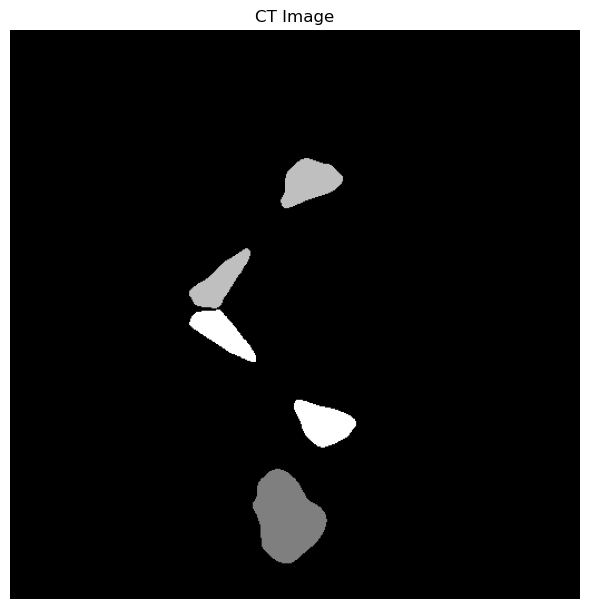

NameError: name 'visualize_slice_and_mask' is not defined

In [2]:
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT Image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

ct_image_path = r"Dataset\Output_mask\filtered_common_40_mask.nii.gz" 
ct_image = nib.load(ct_image_path).get_fdata()
slice_idx = ct_image.shape[2] // 2 -100
visualize_slice(ct_image,slice_idx)
ct_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii" 
ct_image = nib.load(ct_image_path).get_fdata()
mask_path = r"Dataset\COMMON_images_masks\common_40_mask.nii"
mask = nib.load(mask_path).get_fdata()
visualize_slice_and_mask(ct_image, mask, slice_idx)

# Task 2: Create the functions for registration (other file)

# Task 3: Atlas-based segmentation

In [37]:
import Codes.Registration as reg
def visualize_slice(ct_image, slice_idx):
    plt.figure(figsize=(12, 6))

    # CT Image
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image[:, :, slice_idx], cmap="gray")
    plt.title("CT Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## a) Registration of the group images on the common_40 

In [27]:
# Load the images
ref_image_path = r"Dataset\COMMON_images_masks\common_40_image.nii"
ref_image = sitk.ReadImage(ref_image_path,sitk.sitkFloat32)

moving_image_paths = [r"Dataset/GROUP_images/g1_53_image.nii",
                      r"Dataset/GROUP_images/g1_54_image.nii",
                      r"Dataset/GROUP_images/g1_55_image.nii"]
moving_images = []
for moving_image_path in moving_image_paths:
    moving_image = sitk.ReadImage(moving_image_path,sitk.sitkFloat32)
    moving_images.append(moving_image)

In [55]:
def est_lin_transf(im_ref, im_mov, mask = None):
    """
    Estimate linear (affine) transform to align `im_mov` to `im_ref`
    and return the transform parameters.
    """
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    
    # Similarity metric settings
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)  # Can use other metrics like Mattes Mutual Information
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)  # Use a small percentage of pixels for speed
    
    if mask is not None:
        registration_method.SetMetricFixedMask(mask)
        
    # Interpolation
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Optimizer settings
    registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=500, convergenceMinimumValue=1e-3, convergenceWindowSize=20)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Transformation model
    initial_transform = sitk.CenteredTransformInitializer(im_ref, im_mov, sitk.AffineTransform(im_ref.GetDimension()), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Perform registration
    final_transform = registration_method.Execute(sitk.Cast(im_ref, sitk.sitkFloat32), 
                                                  sitk.Cast(im_mov, sitk.sitkFloat32))

    print("--------")
    print("Affine registration:")
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print("Optimizer stop condition: {0}".format(registration_method.GetOptimizerStopConditionDescription()))
    print("Number of iterations: {0}".format(registration_method.GetOptimizerIteration()))
    print("--------")
    
    return final_transform

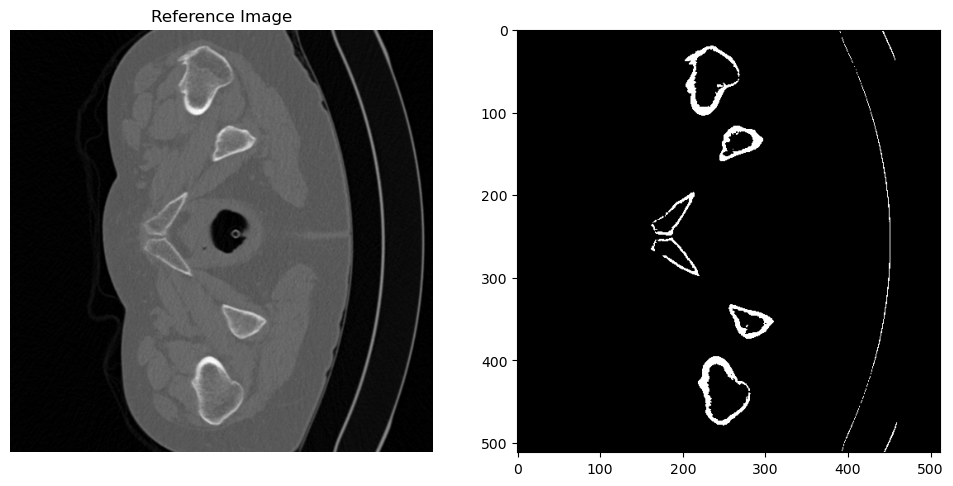

In [29]:
ref_array = sitk.GetArrayFromImage(ref_image)
ref_array = ref_array.swapaxes(0, 2)
mask = np.logical_and(ref_array>300,ref_array<3000) # Hounsfield values for bones : 300-3000
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(ref_array[:, :, ref_array.shape[2]//2 - 100], cmap="gray")
plt.title("Reference Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(mask[:, :, ref_array.shape[2]//2 - 100], cmap="gray")

In [30]:
def numpy_to_sitk(mask_array, reference_image):
    """
    Convert a binary Numpy mask to a SimpleITK image.
    
    Parameters:
    - mask_array: The Numpy array representing the mask (binary).
    - reference_image: A SimpleITK image that defines the geometry of the mask
    
    Returns:
    - SimpleITK mask image
    """
    # Ensure the mask is binary (0 or 1)
    mask_array = np.round(mask_array).astype(np.uint8)
    
    # Convert the Numpy array to a SimpleITK image
    mask_sitk = sitk.GetImageFromArray(mask_array)
    
    # Set the spatial properties (spacing, origin, direction) to match the reference image
    mask_sitk.SetSpacing(reference_image.GetSpacing())
    mask_sitk.SetOrigin(reference_image.GetOrigin())
    mask_sitk.SetDirection(reference_image.GetDirection())
    
    return mask_sitk

In [62]:
print("Moving image origin:", moving_image.GetOrigin())
print("Reference image origin:", ref_image.GetOrigin())
print("Moving image spacing:", moving_image.GetSpacing())
print("Reference image spacing:", ref_image.GetSpacing())
print("Moving image size:", moving_image.GetSize())
print("Reference image size:", ref_image.GetSize())

Moving image origin: (-206.1611328125, -348.1611328125, -894.9000244140625)
Reference image origin: (-168.66796875, -298.66796875, 728.7000122070312)
Moving image spacing: (0.677734375, 0.677734375, 0.800048828125)
Reference image spacing: (0.6640625, 0.6640625, 0.79998779296875)
Moving image size: (512, 512, 301)
Reference image size: (512, 512, 286)


In [56]:
# Find the transformations for the moving images
transformations = []
sitk_mask = numpy_to_sitk(mask.swapaxes(0,2), ref_image)
for i,moving_image in enumerate(moving_images):
    print(0)
    moving_image_res = sitk.Resample(moving_image, ref_image.GetSize(), sitk.Transform(), sitk.sitkLinear, ref_image.GetOrigin(), ref_image.GetSpacing(), ref_image.GetDirection(), 0.0, moving_image.GetPixelID())
    transformation = est_lin_transf(ref_image, moving_image_res, sitk_mask)
    transformations.append(transformation)

0
--------
Affine registration:
Final metric value: 373784.95657414786
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 19.
Number of iterations: 19
--------
0
--------
Affine registration:
Final metric value: 380811.81724475237
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 19.
Number of iterations: 19
--------
0
--------
Affine registration:
Final metric value: 380762.0432674299
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 19.
Number of iterations: 19
--------


In [49]:
moving_image_res.GetSize(), ref_image.GetSize(), sitk_mask.GetSize()

((512, 512, 286), (512, 512, 286), (512, 512, 286))

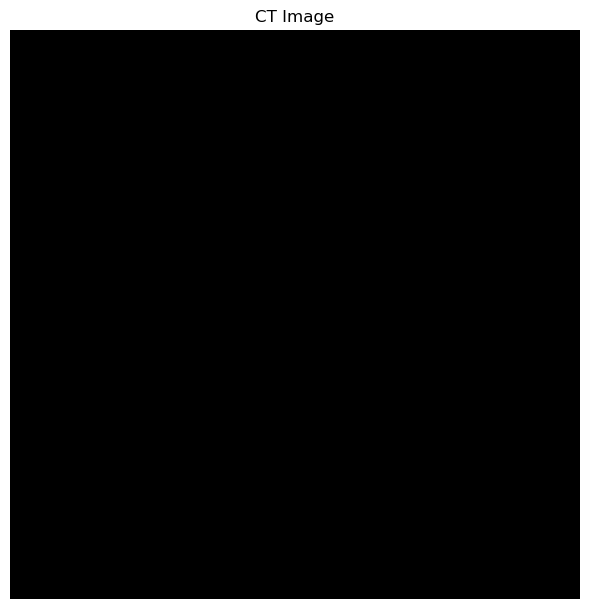

In [58]:
visualize_slice(sitk.GetArrayFromImage(moving_image_res).swapaxes(0,2), moving_image_res.GetSize()[0]//2)

In [53]:
transformation = transformations[2]

In [54]:
transformation.GetParameters()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)

In [35]:
def apply_lin_transf_2(im_mov, lin_xfm):
    """
    Apply given linear transformation to `im_mov`.
    
    Parameters:
        im_mov: SimpleITK.Image - Moving image to transform.
        lin_xfm: SimpleITK.Transform - Linear transformation to apply.

    Returns:
        transformed_image: SimpleITK.Image - Transformed moving image.
    """
    transformed_image = sitk.Resample(
        im_mov, 
        im_mov,  # Use the original image as a template
        lin_xfm, 
        sitk.sitkLinear, 
        0.0,  # Default pixel value
        im_mov.GetPixelID()
    )
    return transformed_image

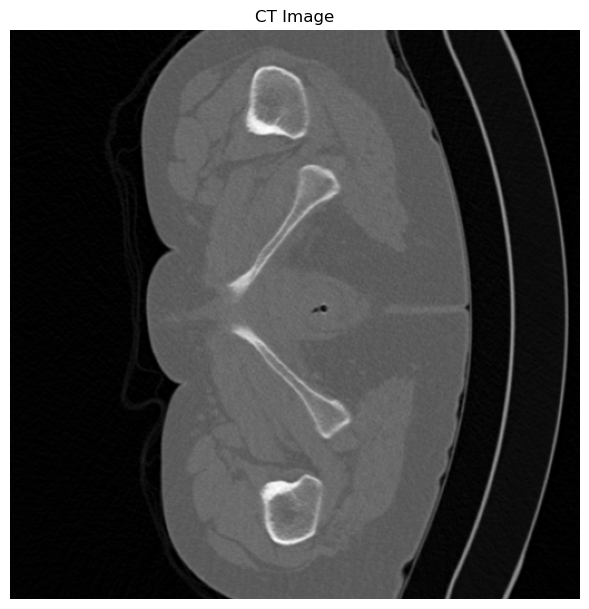

Plotting transformed image 0...


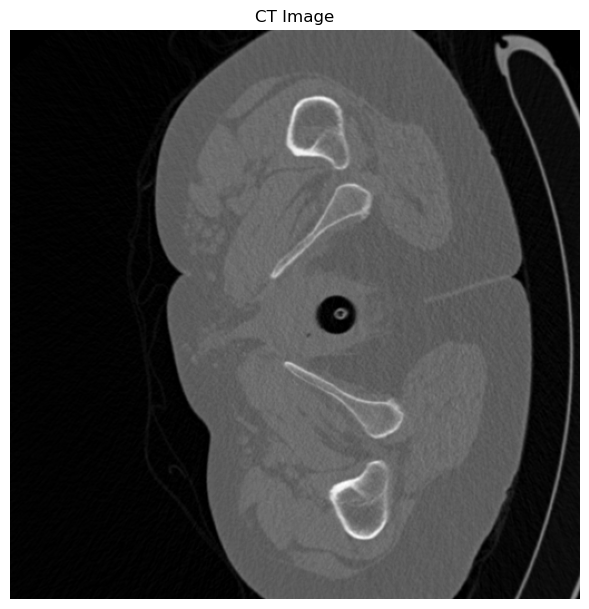

Plotting transformed image 1...


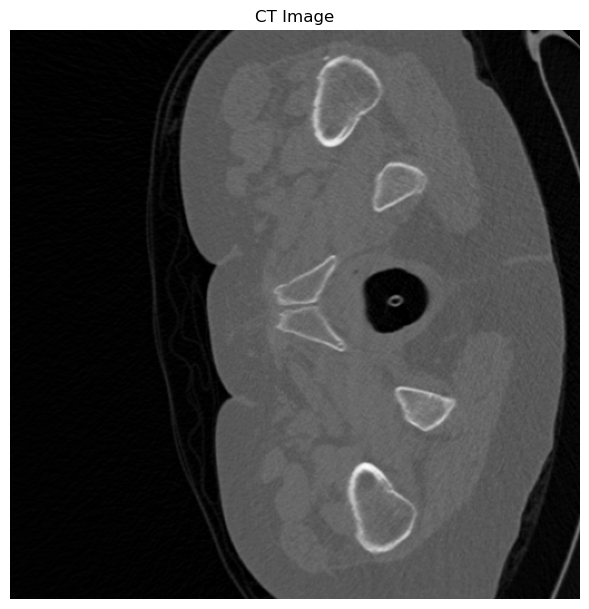

Plotting transformed image 2...


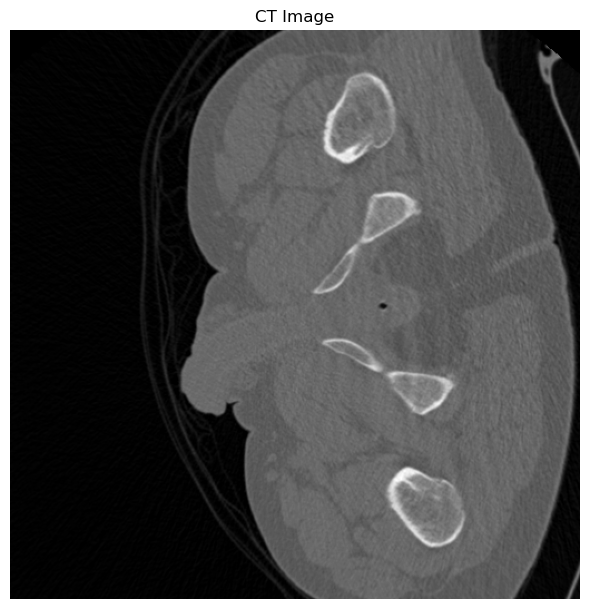

In [64]:
# Plot the transformations to check the results
ref_array = sitk.GetArrayFromImage(ref_image)
ref_array = ref_array.swapaxes(0, 2)
visualize_slice(ref_array, 20)
for i, transformation in enumerate(transformations):
    print(f"Plotting transformed image {i}...")
    # transformed_image = apply_lin_transf_2(moving_images[i], transformation)
    # transformed_array = sitk.GetArrayFromImage(transformed_image)
    # transformed_array = transformed_array.swapaxes(0, 2)
    # visualize_slice(transformed_array, transformed_array.shape[2] // 2)
    moving_array = sitk.GetArrayFromImage(moving_images[i])
    moving_array = moving_array.swapaxes(0, 2)
    visualize_slice(moving_array, 30)

In [39]:
transformation

<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x000001B980679A50> >

## b) Transform the masks and do a majority voting for segmentation

## c) Do the same for common_41 and common_42

# Task 4: Accuracy assessment

# Task 5: Image classification